In [156]:
import collections

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk import tokenize
from tqdm.notebook import tqdm

from pan20 import chis, fake, noble, util

In [36]:
_data = fake.load_data()
truth = fake.load_truth()

In [39]:
data = {}
for author in _data.author.unique():
    author_data = _data[_data.author == author]
    data[author] = {
        'tweets': list(author_data.text.values),
        'label': next(x for x in truth if x['author'] == author)['label'],
    }

In [40]:
data['f4zgi7ym7829iqld6x77q6mh30s0rf86']

{'tweets': ['Thanks "ArtistRack" For Following Me !!! #URL#',
  'Thanks "Sally Mansfield" For Following Me !!! #URL#',
  'Thanks "Simão" For Following Me !!! #URL#',
  'RT BBCWorld "Danish prince refuses to be buried with his wife, the queen #URL#"',
  'RT Reuters "Bieber says he\'s \'never going to be perfect\' after tour cancellation #URL# #URL#"',
  'RT Reuters "U.S. to reject biofuel program tweaks in blow to refiners, Icahn: sources #URL# #URL#"',
  'RT Reuters "Congress heads into break with Republican promises unfulfilled #URL#"',
  'RT MistahLarry "How much of the world\'s wealth is hidden offshore? - BBC News #URL# #URL#"',
  'RT nytimes "RT jonathanellis: Trump also talked about putting coal miners back to work — we did a fact-check on hi… #URL#"',
  'RT nytimes "Foxes and other furry creatures could be Lyme disease\'s worst enemy #URL#"',
  'RT Reuters "Plant-based meats whet U.S. summer grilling appetites #URL# #URL#"',
  'RT Reuters "Cyber expert who stopped \'WannaCry\' a

## Some Basic Features

- `n_RT`
- `n_URL` in non retweets

Wonder about correlation with labels.

In [77]:
def get_retweets(tweets):
    return [x for x in tweets if x.startswith('RT ')]

def get_non_retweets(tweets):
    return [x for x in tweets if not x.startswith('RT ')]

In [78]:
feats = []
for author in data:
    rt = get_retweets(data[author]['tweets'])
    nrt = get_non_retweets(data[author]['tweets'])
    n_url = 0
    for x in nrt:
        n_url += x.count('#URL#')
    feats.append({
        'author': author,
        'n_RT': len(rt),
        'n_URL': n_url,
        'label': data[author]['label'],
    })
feats = pd.DataFrame(feats)

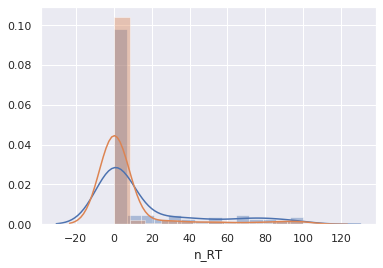

In [79]:
_ = sns.distplot(feats[feats.label == 0].n_RT)
_ = sns.distplot(feats[feats.label == 1].n_RT)
plt.show()

In [80]:
feats.groupby('label').mean()

,n_RT,n_URL
label,,
0,15.453333,102.206667
1,7.233333,108.373333


**TODO**: cut the data up into 5 equal chunks with equal label proportions and check how much variance in these features.

## Distribution over Retweeted Accounts

In [98]:
def get_entity(rt):
    rt = rt.replace('RT ', '')
    ent = rt.split(' ')[0]
    if ent.endswith(':'):
        ent = ent[0:-1]
    return ent

In [99]:
rt_ents = []
for author in data:
    rts = get_retweets(data[author]['tweets'])
    ents = [get_entity(x) for x in rts]
    for ent in ents:
        rt_ents.append({
            'author': author,
            'ent': ent,
            'label': data[author]['label'],
            'n': 1,
        })
rt_ents = pd.DataFrame(rt_ents)

In [100]:
counts = rt_ents.groupby(['ent', 'label', 'author']).count().reset_index()
means = counts.groupby(['ent', 'label']).mean().reset_index()
means.head()

,ent,label,n
0,#HASHTAG#,0,32.000000
1,#USER#,0,32.412698
2,#USER#,1,33.357143
3,'Dancing,0,1.000000
4,'Mr.,0,1.000000


In [103]:
political = [
    'nytimes',
    'realDonaldTrump',
    'POTUS',
    'BBCWorld',
]
means[means.ent.isin(political)]

,ent,label,n
12,BBCWorld,0,11.0
56,POTUS,1,23.0
97,nytimes,0,18.0
98,realDonaldTrump,1,77.0


That's a pretty interesting sampling. But, I reckon they might be intentionally trying to present a much different distribution in the test set. Because this distribution is seriously stacked.

## Tendency to Retweet "Mainstream Media"

This has got to be correlated with the 0 label. Would need a list. Could attempt to extract from this distribution, but afraid it would be too limited to generalize. A custom list is needed. Also need to consider normalization. Or, rather, getting lists of account and display names for all the various mainstream media sources. Looks like US and UK?

I am not inclined to try conservative versus liberal, as it might be easy for them to just shift the distribution at test time. I think the mainstream media feature captures this phenomenon still here, and is more likely to generalize.

## Function word category usage

Grab the free function word list a la LIWC. I somehow doubt this as a feature. Worth a look though.

In [106]:
noble_dict = noble.NobleDict()

In [124]:
profiles = {}
with tqdm(total=len(data)) as pbar:
    for author in data:
        profiles[author] = {'n': 0, 'f': 0}
        for cat in noble.cats:
            profiles[author][cat] = 0
        non_rts = get_non_retweets(data[author]['tweets'])
        for tweet in non_rts:
            words = [x.strip().lower() for x in tokenize.word_tokenize(tweet)]
            profiles[author]['n'] += len(words)
            for word in words:
                added = False
                for cat in noble_dict.cats_for(word):
                    profiles[author][cat] += 1
                    if not added:
                        profiles[author]['f'] += 1
                        added = True
        pbar.update()

In [126]:
cat_data = []
for author in profiles:
    x = {
        'author': author,
        'n': profiles[author]['n'],
        'f': profiles[author]['f'],
        'label': data[author]['label'],
    }
    for cat in noble.cats:
        if x['n'] == 0:
            x[cat] = 0.
            x['ff'] = 0.
        else:
            x[cat] = profiles[author][cat] / x['n']
            x['ff'] = x['f'] / x['n']
    cat_data.append(x)
cat_data = pd.DataFrame(cat_data)

In [127]:
cat_data.head()

,author,n,f,label,adverbs,ff,articles,auxiliary_verbs,conjunctions,impersonal_pronouns,personal_pronouns,prepositions,quantifiers
0,f4zgi7ym7829iqld6x77q6mh30s0rf86,436,72,0,0.011468,0.165138,0.006881,0.009174,0.064220,0.002294,0.068807,0.068807,0.002294
1,0dwovd7nj6yg9m795ng2c629me0ccmrh,363,69,0,0.063361,0.190083,0.038567,0.005510,0.041322,0.002755,0.002755,0.121212,0.005510
2,rb0jg4y42rgesbbn9yi6ijx0uvf8fijs,1620,449,1,0.059877,0.277160,0.019136,0.045679,0.033333,0.041975,0.068519,0.064815,0.006173
3,ap52gs0xsrckqp5ot84z4qeqx133uu39,1594,383,1,0.045169,0.240276,0.040151,0.033877,0.043287,0.016311,0.034504,0.075910,0.003137
4,snilxp4fgzi281ayieikiwle0xkb1uok,1791,256,1,0.025126,0.142937,0.007259,0.025126,0.017867,0.004467,0.024009,0.054160,0.002233


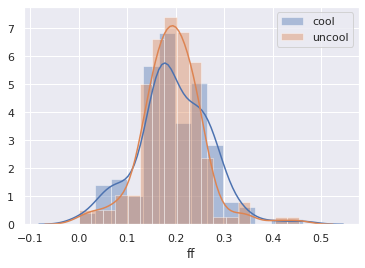

In [129]:
_ = sns.distplot(cat_data[cat_data.label == 0].ff, label='cool')
_ = sns.distplot(cat_data[cat_data.label == 1].ff, label='uncool')
plt.legend()
plt.show()

Hypothesis here was: using more function words means more complicated sentences, means more "intellgence" which, while not always a good thing, is perhaps more likely than not going to mean less spreading of fake news.

Think we can use that one.

In [188]:
ff_preds = cat_data.ff <= 0.25
print(accuracy_score(ff_preds, cat_data.label))
y2 = cat_data[cat_data.ff > 0.25].label
yh2 = [0] * len(y2)
print(len(y2))
print(accuracy_score(y2, yh2))

0.57
53
0.6981132075471698


Investigate distributions for all categories...

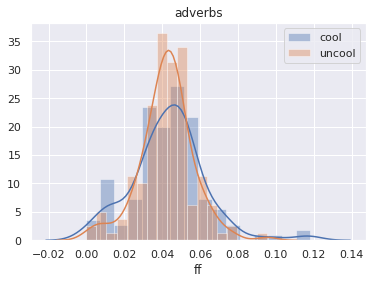

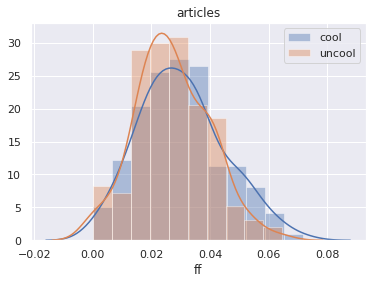

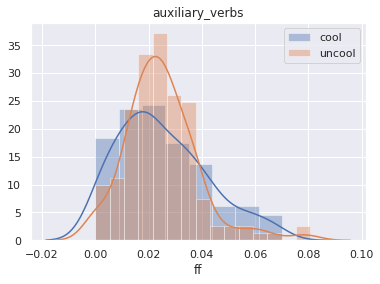

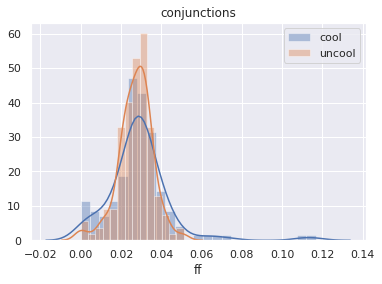

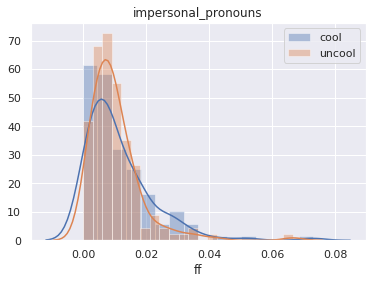

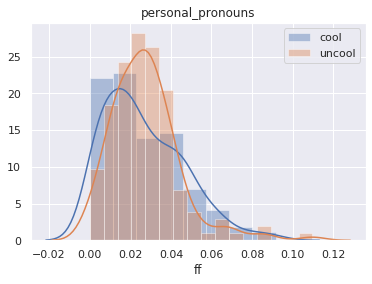

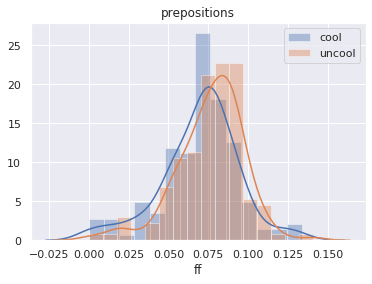

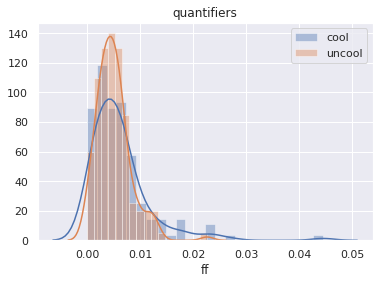

In [147]:
exp_cats = []
for _, x in cat_data.iterrows():
    for cat in noble.cats:
        exp_cats.append({
            'author': x.author,
            'cat': cat,
            'ff': x[cat],
            'label': x.label,
        })
exp_cats = pd.DataFrame(exp_cats)
for cat in noble.cats:
    _ = sns.distplot(exp_cats[(exp_cats.label == 0) & (exp_cats.cat == cat)].ff, label='cool')
    _ = sns.distplot(exp_cats[(exp_cats.label == 1) & (exp_cats.cat == cat)].ff, label='uncool')
    plt.title(cat)
    plt.legend()
    plt.show()

Hard to interpret some of those patterns. The larger concern is overfitting. Without a good theoretical reason for using these individual features, might not be worth using them.

The one exception is maybe prepositions. Seems to show quite a clear pattern. I wonder why?

In [148]:
noble_dict.words_in('prepositions')

['of',
 'in',
 'to',
 'for',
 'with',
 'on',
 'by',
 'at',
 'from',
 'as',
 'into',
 'about',
 'like',
 'after',
 'between',
 'through',
 'over',
 'against',
 'under',
 'without',
 'within',
 'during',
 'before',
 'towards',
 'around',
 'upon',
 'including',
 'among',
 'across',
 'off',
 'behind',
 'since',
 'rather than',
 'until',
 'according to',
 'up to',
 'despite',
 'near',
 'above',
 'per',
 'along',
 'away from',
 'throughout',
 'outside',
 'round',
 'beyond',
 'worth',
 'down',
 'on to',
 'up',
 'due to',
 'inside',
 'plus']

So, so far the features from this section are:
- frequency of function word usage in non-retweets
- frequency of preposition usage in non-retweets (*maybe*)
- frequency of function word usage in retweets of users

to be added to
- proportion of retweets
- proportion of urls

the latter two to be considered more carefully later.

**Wonder about the function word usages in the RTs**. Could be an inclination to retweet more intelligent stuff is less correlated with sharing fake news...

In [162]:
rt_profiles = {}
with tqdm(total=len(data)) as pbar:
    for author in data:
        rt_profiles[author] = {'n': 0, 'f': 0}
        for cat in noble.cats:
            rt_profiles[author][cat] = 0
        rts = get_retweets(data[author]['tweets'])
        for tweet in rts:
            words = [x.strip().lower() for x in tokenize.word_tokenize(tweet)]
            rt_profiles[author]['n'] += len(words)
            for word in words:
                added = False
                for cat in noble_dict.cats_for(word):
                    rt_profiles[author][cat] += 1
                    if not added:
                        rt_profiles[author]['f'] += 1
                        added = True
        pbar.update()

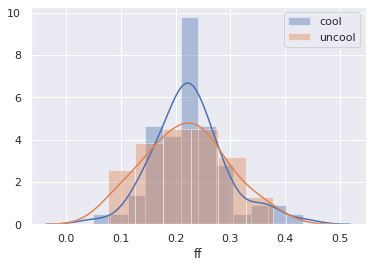

In [177]:
rt_cat_data = []
for author in rt_profiles:
    x = {
        'author': author,
        'n': rt_profiles[author]['n'],
        'f': rt_profiles[author]['f'],
        'label': data[author]['label'],
    }
    for cat in noble.cats:
        if x['n'] == 0:
            x[cat] = 0.
            x['ff'] = 0.
        else:
            x[cat] = rt_profiles[author][cat] / x['n']
            x['ff'] = x['f'] / x['n']
    rt_cat_data.append(x)
rt_cat_data = pd.DataFrame(rt_cat_data)

_ = sns.distplot(rt_cat_data[(rt_cat_data.ff > 0) & (rt_cat_data.label == 0)].ff, label='cool')
_ = sns.distplot(rt_cat_data[(rt_cat_data.ff > 0) & (rt_cat_data.label == 1)].ff, label='uncool')
plt.legend()
plt.show()

Tough to say, but there appears to be a high end where few uncool folks are. It would be interesting to know who they are retweeting there.

In [182]:
z = []
for author in data:
    rts = get_retweets(data[author]['tweets'])
    for tweet in rts:
        words = [x.strip().lower() for x in tokenize.word_tokenize(tweet)]
        n = len(words)
        f = 0
        for word in words:
            if len(noble_dict.cats_for(word)) > 0:
                f += 1
        z.append({
            'author': author,
            'label': data[author]['label'],
            'tweet': tweet,
            'f': f,
            'n': n,
            'ff': f / n if n > 0 else 0.,
        })
z = pd.DataFrame(z)

In [184]:
z.sort_values(by='ff', ascending=False).head(30)

,author,label,tweet,f,n,ff
2085,gzbml73s00h3mlk2kdibc20o3rn2wd17,0,RT #USER#: I was trying to be composed and gla...,16,29,0.551724
1909,z6ejdyu1emh9z9mlsnt5km2suhgbonl9,1,RT #USER#: The US tour is now over. 🥺🥺🤧 Shout ...,20,38,0.526316
2381,sar6hff7d0nogdywvb0vkzivwir7cf3x,0,RT #USER#: Enough is enough. We have to end th...,16,31,0.516129
1326,98as6suith8cskycmudejdvhvmiwi1iy,0,RT #USER#: If I walked into a gallery and slas...,16,31,0.516129
2688,j6eo0r4csyzmbvtv0ty9cfhaujdknb0j,0,RT #USER#: One of the reassuring things about ...,16,31,0.516129
2781,ffw4du7oj59dgi5cobxa4exkvgj5l40y,1,RT #USER#: The investors that needed security ...,17,33,0.515152
3143,nt0kallmiu3m93jvrwgll44wx6ooqnsa,0,RT #USER#: #HASHTAG# She uninvited a friend BE...,16,32,0.500000
3384,fu81uabcsmugx31pazzbqkx9uquc73p6,0,"RT #USER#: Money doesn't need to define you, b...",16,32,0.500000
899,bgszxe71rzsv3tmo1qhuriaf8s3a5awc,0,RT #USER#: How do you break up with someone wi...,9,18,0.500000
2324,gemo5q5llsk44vezvt3rztv0yyfgjaxf,1,"RT #USER#: “And when you're a star, they let y...",18,37,0.486486


At least from the top 30 it looks reasonable. Interestingly, these are all retweets of users. So, if your followees use more function words, and are therefore more thoughtful, you are less likely to spread fake news.

## Should look at $\chi^2$ of unigrams with labels, see if can sort through the signal and the noise

Like to do this both on a non-retweet basis, and an everything basis. Not sure whether a retweet basis is worth it. Maybe it is. Do it anyway.

In [199]:
# first grab a vocab over the whole data
vocab = set([])
with tqdm(total=len(data)) as pbar:
    for author in data:
        for tweet in data[author]['tweets']:
            vocab.update(util.tokenize(tweet, True))
        pbar.update()
vocab = util.IxDict(list(vocab))
len(vocab)

26787

### All

In [200]:
c = {0: {}, 1: {}}
for word in vocab.entities:
    c[0][word] = 0
    c[1][word] = 0
n = {0: 0, 1: 0}
with tqdm(total=len(data)) as pbar:
    for author in data:
        label = data[author]['label']
        for tweet in data[author]['tweets']:
            for word in util.tokenize(tweet, True):
                c[label][word] += 1
                n[label] += 1
        pbar.update()

In [201]:
cua = chis.get_chis(c[1], c[0], n[1], n[0])

In [202]:
cua[cua.token.isin(noble_dict.words_in('prepositions'))]

,token,c1,c2,n1,n2,chi
1200,after,741,391,224789,228737,1.457783e-03
16913,over,361,258,224789,228737,1.998579e-04
23989,under,97,54,224789,228737,1.591426e-04
1212,against,133,89,224789,228737,1.037869e-04
923,about,560,467,224789,228737,9.793291e-05
24213,up,480,401,224789,228737,8.236340e-05
2176,at,1241,1120,224789,228737,7.942973e-05
15903,near,50,29,224789,228737,7.094674e-05
9052,for,2044,2265,224789,228737,6.690555e-05
23287,to,4296,4189,224789,228737,3.611770e-05


In [207]:
cua[cua.c2 > 0].head(60)

,token,c1,c2,n1,n2,chi
12401,jordyn,104,2,224789,228737,0.023168
23664,trump,1134,314,224789,228737,0.009728
24284,user,2316,5727,224789,228737,0.009058
22300,sumo,42,1,224789,228737,0.007486
11829,instyl,83,4,224789,228737,0.006956
5113,clinton,167,16,224789,228737,0.006368
3527,border,167,16,224789,228737,0.006368
10886,hillari,162,17,224789,228737,0.005529
5327,comei,36,1,224789,228737,0.005456
4240,cannabi,66,4,224789,228737,0.004286


## LIWC cats would be worthwhile

## Something with RoBERTa output vectors

Maybe just take CLS vectors. Some kind of combine operation into a final feature vector for linear classification.

## Wondering if Verbs would be any use

Might find inciting ones.

## Classifier Interface

- 10-fold CV
- Hyperparameter tuning?

In [217]:
import random

from sklearn.model_selection import StratifiedKFold

In [215]:
kf = StratifiedKFold(n_splits=10)  # is deterministic, no need to set random_state

In [216]:
help(kf)

Help on StratifiedKFold in module sklearn.model_selection._split object:

class StratifiedKFold(_BaseKFold)
 |  StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
 |  
 |  Stratified K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets.
 |  
 |  This cross-validation object is a variation of KFold that returns
 |  stratified folds. The folds are made by preserving the percentage of
 |  samples for each class.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle each class's samples before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by the random numbe

In [219]:
for tr, te in kf.split(list(range(100)), [random.choice([0, 1]) for _ in range(100)]):
    print(len(tr))
    print(len(te))
    raise Exception

90
10


Exception: 

In [22]:
from pan20.fake import feats, load, load_truth

data = load()
truth = load_truth(as_df=True)
rr = feats.get_all(data, truth)
rr.head()

,author,rt_freq,func_freq,rt_usr_func_freq,label
0,06ct0t68y1acizh9eow3g5rhancrppr8,0.00,0.275472,0.000000,1
1,071nxc49ihpd0jlfmvn2lghtayy3b5n9,0.02,0.238128,0.288889,0
2,09py5qescynpnnckmzueqzr2y49moh1o,0.00,0.229899,0.000000,0
3,0dwovd7nj6yg9m795ng2c629me0ccmrh,0.81,0.241611,0.237834,0
4,0ibi364m7i7l01xi4xqafyathrmrrnll,0.53,0.207589,0.227783,1


In [42]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

x_feats = [
    #'rt_freq', 
    #'func_freq', 
    'rt_usr_func_freq'
]
X = rr[x_feats].values
y = rr.label.values

# clf = svm.SVC(kernel='linear', C=1)
# clf = GaussianNB()
clf = LogisticRegression()

scores = cross_val_score(clf, X, y, cv=5)
print(scores)
np.mean(scores)

[0.55       0.71666667 0.55       0.6        0.65      ]


0.6133333333333333

In [ ]:
accs = []
for train, test in folds:
    hyper_params = grid(train)
    fit(train, hyper_params)
    acc = evaluate(test)
    accs.append(acc)
print(mean(accs))